# Analysis of chemo diversity on pharmacological and biological activities

Datasets are obtained by querying scopus

In [1]:
from pathlib import Path
from loader import load_chemo_activities, sort_by_class

FILENAME = Path("results/activities_2021-11-10_12-34-35.csv")
dataset = load_chemo_activities(FILENAME)

INFO:scopus_api:load_chemo_activities('results/activities_2021-11-10_12-34-35.csv') loaded


Pharmacological and biological activities, with their classes of activity (generalization) (first 10)

In [62]:
from itertools import islice
list(islice(dataset.activities.items(), 0, 10))

[('antioxidant', 'abiotic'),
 ('drought', 'abiotic'),
 ('metal', 'abiotic'),
 ('salt', 'abiotic'),
 ('uv', 'abiotic'),
 ('antifeedant', 'allelopathy'),
 ('arbuscula', 'allelopathy'),
 ('attractant', 'allelopathy'),
 ('germination', 'allelopathy'),
 ('herbicidal', 'allelopathy')]

Chemical compounds, with their classes of activity (generalization)

In [63]:
list(islice(dataset.compounds.items(), 0, 10))

[('acridine', 'alkaloid'),
 ('benzylamine', 'alkaloid'),
 ('colchicine', 'alkaloid'),
 ('cyclopeptide', 'alkaloid'),
 ('imidazole', 'alkaloid'),
 ('indole', 'alkaloid'),
 ('indolizidine', 'alkaloid'),
 ('isoquinoline', 'alkaloid'),
 ('isoxazole', 'alkaloid'),
 ('muscarine', 'alkaloid')]

## Correspondance Analysis

In [4]:
import pandas as pd
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))

In [66]:
# converts to pandas
df = pd.DataFrame(dataset.data).T
df.columns.rename('Activity', inplace=True)
df.index.rename('Compound', inplace=True)
df.head()

Activity,antioxidant,drought,metal,salt,uv,antifeedant,arbuscula,attractant,germination,herbicidal,...,antiviral,arthritis,burns,cardiovascular,cytotoxicity,obesity,rheumatism,sedative,wound,toxicity
Compound,,,,,,,,,,,,,,,,,,,,,
acridine,262,2,250,163,78,1,0,0,11,1,...,117,26,16,45,1273,3,0,8,76,396
benzylamine,70,0,163,79,23,0,0,0,4,6,...,23,12,1,87,121,34,0,6,18,101
colchicine,185,4,82,185,19,0,0,0,44,0,...,102,1594,31,592,1243,168,19,34,219,860
cyclopeptide,57,1,167,34,16,0,0,0,17,1,...,92,674,1,77,509,44,6,4,49,168
imidazole,1069,7,2454,1183,297,3,0,1,52,8,...,1187,382,120,1253,2776,290,1,480,452,1748


### Using Prince

Here a demo of <https://en.wikipedia.org/wiki/Correspondence_analysis> - **CA**, a kind of PCA for two-ways contingency tables. See <https://cedric.cnam.fr/fichiers/art_3066.pdf>. Here I use first a Python lib, then i'll build de CA from scratch using numpy.

In [6]:
# see https://github.com/MaxHalford/prince
import prince

ca = prince.CA(n_components=2, n_iter=3, copy=True, check_input=True, engine="auto", random_state=42)
ca = ca.fit(df)

ca.explained_inertia_

[0.3572050603478939, 0.17664755027476908]

In [67]:
ca.row_coordinates(df)[:10]

,0,1
acridine,-0.351,-0.391
benzylamine,-0.349,-0.372
colchicine,-0.759,-0.409
cyclopeptide,-0.807,0.139
imidazole,-0.476,-0.277
indole,-0.349,-0.246
indolizidine,-0.580,-0.390
isoquinoline,-0.494,-0.406
isoxazole,-0.674,-0.172
muscarine,-0.633,-0.616


In [68]:
ca.column_coordinates(df)[:10]

,0,1
antioxidant,0.811,0.014
drought,0.820,-0.106
metal,-0.109,-0.160
salt,-0.435,-0.493
uv,0.339,-0.087
antifeedant,-0.057,-0.116
arbuscula,-0.019,0.077
attractant,-0.133,0.112
germination,0.522,-0.055
herbicidal,-0.467,-0.433


Here, CA explains about 53% of inertia. **Question** is it satsifying?

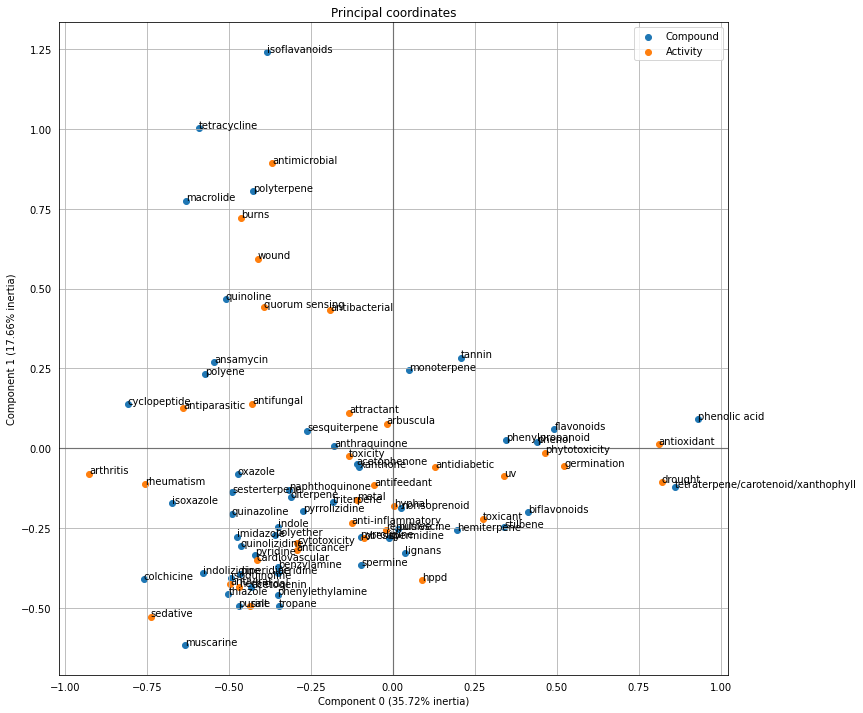

In [8]:
ax = ca.plot_coordinates(
     X=df,
     ax=None,
     figsize=(12, 12),
     x_component=0,
     y_component=1,
     show_row_labels=True,
     show_col_labels=True
 )


### From scratch with numpy

We use <https://statmath.wu.ac.at/courses/CAandRelMeth/caipA.pdf> as a reference specification.
The exercise here amounts to redefine manually <https://github.com/MaxHalford/prince/blob/master/prince/ca.py>.

In [119]:
import numpy as np
np.set_printoptions(precision=4, suppress=True)

X = df.to_numpy()
N = np.sum(X)
Z = X / N
print(f"{N = }")
X

N = 386562


array([[ 262,    2,  250, ...,    8,   76,  396],
       [  70,    0,  163, ...,    6,   18,  101],
       [ 185,    4,   82, ...,   34,  219,  860],
       ...,
       [   7,    0,    0, ...,    1,    2,   12],
       [7438,  329,  573, ...,    3,   96,  806],
       [1113,    3,   48, ...,   22,  196,  400]])

In [69]:
C = np.sum(X, axis = 0) # Z @ np.ones(X.shape[0])
# print(f"{C = }")
R = np.sum(X, axis = 1) # X @ np.ones(X.shape[1])
# print(f"{R = }")


c = np.sum(Z, axis = 0)
print(f"{100*c = }")
print(f"{np.sum(c) = }")
r = np.sum(Z, axis = 1)
print(f"{100*r = }")
print(f"{np.sum(r) = }")

100*c = array([23.6011,  0.3521,  7.2392,  3.9463,  1.9673,  0.0616,  0.0028,
        0.0347,  0.8133,  0.0579,  0.0039,  0.0101,  0.3893,  0.2745,
        0.0166,  0.0352,  5.1937,  6.9668,  1.4538,  2.068 ,  4.8116,
        7.4128,  0.3311,  2.7307,  2.0775,  0.3485,  2.9814, 12.5869,
        1.435 ,  0.0199,  0.6995,  2.0576,  8.0192])
np.sum(c) = 1.0
100*r = array([ 0.8475,  0.2483,  1.7459,  0.8074,  4.9845,  4.1802,  0.0235,
        0.6229,  0.8312,  0.0222,  0.5958,  0.0197,  1.9645,  1.4365,
        0.3166,  5.7872,  0.9841,  0.2176,  0.8591,  4.0402,  0.0486,
        0.3839,  0.3906,  4.2363,  0.0776,  0.7148,  1.3708,  0.2393,
       14.7208,  0.0005,  0.7587,  0.9357, 17.9518,  3.6134,  0.2708,
        1.6763,  4.2979,  0.618 ,  0.096 ,  0.0367,  2.0788,  0.4475,
        0.2789,  5.5179,  1.1388,  0.0466,  0.2538,  0.0241,  0.0008,
        1.9084,  0.0636,  3.3974,  1.8701])
np.sum(r) = 0.9999999999999999


In [11]:
Dc = np.diag(c)
Dr = np.diag(r)

print(f"{Z.shape = }")
print(f"{r[:, np.newaxis].shape = }")
print(f"{c[:, np.newaxis].shape = }")

Zc = (Z - (r[:, np.newaxis]@(c[:, np.newaxis].T)))
# Note that the subtraction of the matrix rc T from Z is equivalent to a double centering of the matrix
S = np.diag(r ** (-0.5)) @ Zc @ np.diag(c ** (-0.5))
S


Z.shape = (53, 33)
r[:, np.newaxis].shape = (53, 1)
c[:, np.newaxis].shape = (33, 1)


array([[-0.0296, -0.0045,  0.0013, ..., -0.005 ,  0.0017,  0.0132],
       [-0.0167, -0.003 ,  0.018 , ..., -0.0004, -0.0006,  0.0044],
       [-0.0567, -0.0065, -0.0296, ..., -0.0031,  0.0109,  0.022 ],
       ...,
       [-0.0108, -0.0015, -0.0068, ..., -0.0009, -0.0022, -0.0028],
       [ 0.1253,  0.0669, -0.0197, ..., -0.0149, -0.017 , -0.0122],
       [-0.0231, -0.0072, -0.0334, ..., -0.0065,  0.0062, -0.012 ]])

In [37]:
from scipy import linalg
U, D, Vt = linalg.svd(S)
Da = (np.eye(U.shape[0], Vt.shape[0]) * D)

print(f"{ U.shape,  D.shape, Da.shape, Vt.shape = }")

# SVD ensures that Vt  @ Vt.T == I == U.T @ U
assert np.allclose(Vt  @ Vt.T, np.identity(Vt.shape[0]))
assert np.allclose(U.T  @ U, np.identity(U.shape[0]))


 U.shape,  D.shape, Da.shape, Vt.shape = ((53, 53), (33,), (53, 33), (33, 33))


In [70]:
r_std_coords = np.diag(r ** (-0.5)) @ U
r_coords = r_std_coords @ Da
r_coords[:10, :2]

array([[-0.3506,  0.3909],
       [-0.3489,  0.3723],
       [-0.7588,  0.409 ],
       [-0.8074, -0.139 ],
       [-0.4762,  0.2767],
       [-0.349 ,  0.2456],
       [-0.5799,  0.3904],
       [-0.4942,  0.4061],
       [-0.674 ,  0.1722],
       [-0.6331,  0.6162]])

In [71]:
c_std_coords = np.diag(c ** (-0.5)) @ Vt.T
c_coords = c_std_coords @ Da.T
c_coords[:10, :2]

array([[ 0.8109, -0.0141],
       [ 0.8196,  0.1063],
       [-0.1088,  0.1602],
       [-0.4354,  0.4934],
       [ 0.339 ,  0.0868],
       [-0.0565,  0.1157],
       [-0.0187, -0.0773],
       [-0.1332, -0.1121],
       [ 0.522 ,  0.0547],
       [-0.4673,  0.4332]])

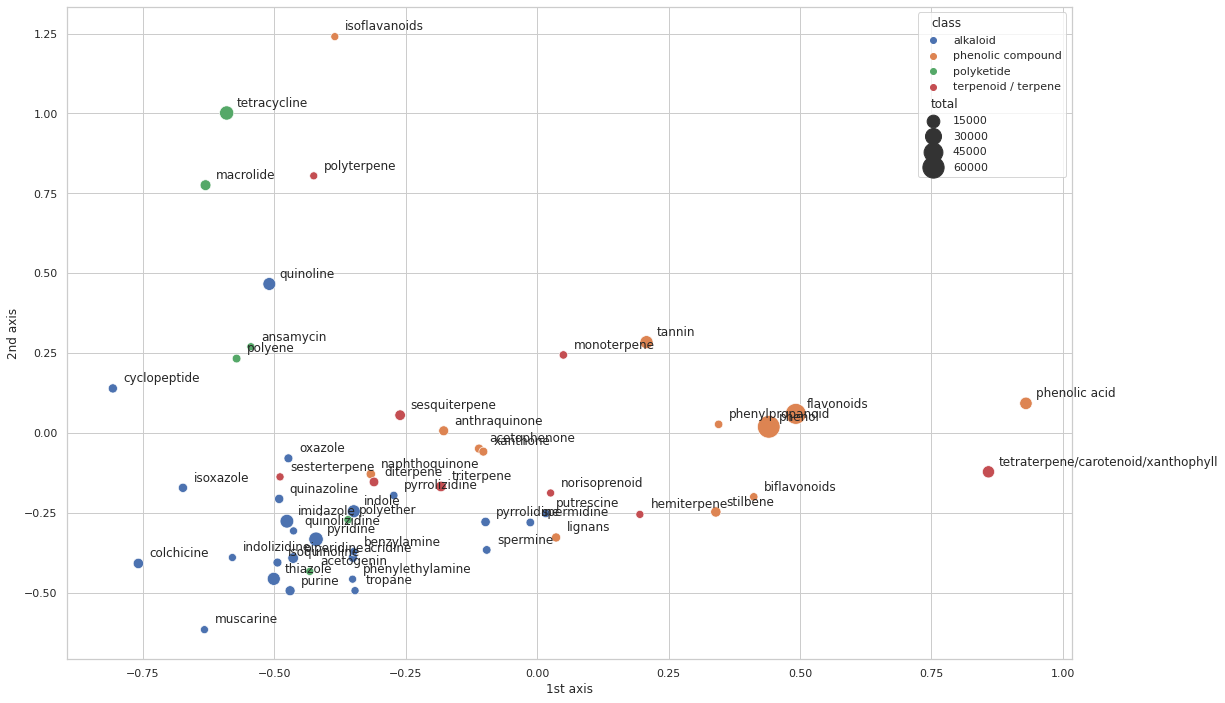

In [115]:
df_r = pd.DataFrame(index=df.index)
df_r["1st axis"] = r_coords[:, 0]
df_r["2nd axis"] = -r_coords[:, 1]
df_r.index.rename('Compound', inplace=True)
df_r["class"] = [dataset.compounds[x] for x in df_r.index]
df_r["total"] = R

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(18,12))

sns.scatterplot(data = df_r, x="1st axis", y = "2nd axis",  hue="class", size="total", sizes=(64, 512))
for index, row in df_r.iterrows():
    ax.annotate(index, (row["1st axis"] + .02, row["2nd axis"] + .02))

# sns.scatterplot(x=r_coords[:, 0, y=-r_coords[:, 1])
# sns.scatterplot(x=c_coords[:, 0], y=-c_coords[:, 1])]


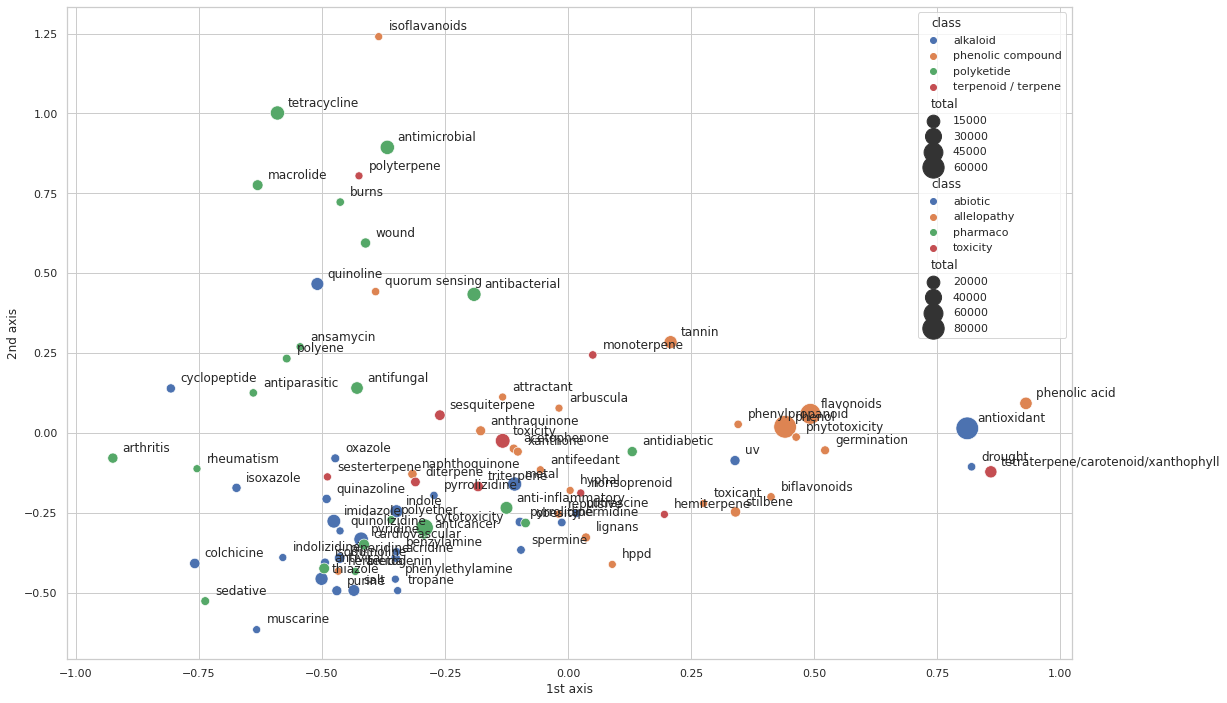

In [126]:
df_c = pd.DataFrame(index = df.columns)
df_c["1st axis"] = c_coords[:, 0]
df_c["2nd axis"] = -c_coords[:, 1]

df_c.index.rename('Activity', inplace=True)
df_c["class"] = [dataset.activities[x] for x in df_c.index]
df_c["total"] = C



fig, ax = plt.subplots(figsize=(18,12))

sns.scatterplot(data = df_r, x="1st axis", y = "2nd axis",  hue="class", size="total", sizes=(64, 512))
for index, row in df_r.iterrows():
    ax.annotate(index, (row["1st axis"] + .02, row["2nd axis"] + .02))

sns.scatterplot(data = df_c, x="1st axis", y = "2nd axis",  hue="class", size="total", sizes=(64, 512))
for index, row in df_c.iterrows():
    ax.annotate(index, (row["1st axis"] + .02, row["2nd axis"] + .02))